In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import json
import matplotlib.pyplot as plt
import seaborn as sns

from functions import join_stocks_crypto

c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
#Find stocks with over the top volatility
df_all_stocks = pd.read_csv('stocks_data_filled.csv',index_col='Date')
cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')
joined_df = join_stocks_crypto(cryptos_df, df_all_stocks, mode = 'stocks_left')

cryptos_list = list(cryptos_df.columns)


log_returns = np.log(df_all_stocks / df_all_stocks.shift(1)).dropna()
daily_volatility = log_returns.std()
annual_volatility = daily_volatility * np.sqrt(252)

annual_volatility.sort_values().tail(20)

c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


PRCT      0.692412
TTD       0.708151
3YU.F     0.747658
MDB       0.755362
SITM      0.765612
RNA       0.797502
AXSM      0.814172
DJT       0.901152
TBA.F     0.916075
ECX       0.923325
RYTM      0.941110
OL5.F     1.315230
SMMT      1.362448
4AH1.F    1.370364
2B5.F     1.385327
PJXC.F    1.894676
LPS1.F    3.012170
WK0.F     3.041260
0DH.F     4.547030
LFU2.F    4.970240
dtype: float64

In [3]:
# df_all_stocks = df_all_stocks.drop(columns=['OL5.F', 'SMMT', '4AH1.F', '2B5.F', 'PJXC.F', 'LPS1.F', 'WK0.F', '0DH.F', 'LFU2.F'])

# df_all_stocks.to_csv('stocks_data_filtered_volatility.csv')

# tickers = list(df_all_stocks.columns)

In [5]:
import os
folder = 'out_of_sample_direct_results/'
for file in os.listdir(folder):
    if '.xlsx' in file:
        df = pd.read_excel(folder + file, engine='openpyxl', sheet_name='annualised_return')

In [17]:
pd.read_csv('full_table_silhouette_balance_geometric.csv').sort_values('total_score', ascending=False)

,Unnamed: 0,clusters,silhouette_score,method,linkage,return_mode,window_size/span,df_mode,window_size,min_per_cluster,max_per_cluster,min_max_delta,silhouette_norm,delta_norm,total_score
284,604,4,0.579029,kmeans,not_applicable,geometric,30,weekly,30.0,0.1532,0.3874,0.2342,0.961366,0.786744,0.874055
285,605,5,0.494025,kmeans,not_applicable,geometric,30,weekly,30.0,0.0946,0.2973,0.2027,0.872831,0.819884,0.846358
287,607,7,0.471225,kmeans,not_applicable,geometric,30,weekly,30.0,0.0811,0.2883,0.2072,0.849085,0.815150,0.832117
286,606,6,0.482468,kmeans,not_applicable,geometric,30,weekly,30.0,0.0405,0.2928,0.2523,0.860795,0.767701,0.814248
272,592,4,0.346529,kmeans,not_applicable,geometric,21,weekly,21.0,0.1577,0.3288,0.1712,0.719210,0.853025,0.786117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,783,7,-0.092348,kshape,not_applicable,geometric,60,3day,NaN,NaN,NaN,NaN,0.262105,NaN,NaN
384,784,4,0.030101,kshape,not_applicable,geometric,60,full,NaN,NaN,NaN,NaN,0.389639,NaN,NaN
385,785,5,0.040678,kshape,not_applicable,geometric,60,full,NaN,NaN,NaN,NaN,0.400656,NaN,NaN
386,786,6,0.087180,kshape,not_applicable,geometric,60,full,NaN,NaN,NaN,NaN,0.449089,NaN,NaN


CLUSTERING INSIGHTS

In [6]:
df_all_stocks = pd.read_csv('stocks_data_filtered_volatility.csv',index_col='Date')
cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')
tickers_all = list(df_all_stocks.columns) + list(cryptos_df.columns) 

exchanges_dict = dict()
for ticker in tickers_all:
    dat = yf.Ticker(ticker)
    if ticker in list(cryptos_df.columns):
        exchanges_dict[ticker] = 'crypto'
    else:
        exchange = dat.info['exchange']
        exchanges_dict[ticker] = exchange

exchanges_dict

with open('tickers_with_exchanges.json', 'w') as fp:
    json.dump(exchanges_dict, fp)


In [7]:
cluster_labels = dict()
for method in ['ahc', 'kmeans', 'kshape']:
    with open(f'tickers_labels_{method}.json') as f:
        clusters = json.load(f)
        cluster_labels[method] = clusters


with open('tickers_with_exchanges.json') as f:
    exchanges_dict = json.load(f)

In [8]:
#KSHAPE try more clusters
from functions import run_clustering_model

df = joined_df.rolling(window=3, center=True).mean()
labels, tickers_with_labels_kshape, _, _ = run_clustering_model(df, n_clus=13, model_name='kshape', linkage=None, return_mode='geometric', n_init=3)



c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [9]:
cluster_labels['kshape'] = tickers_with_labels_kshape
#cluster_labels['kshape']

In [10]:
def visualise_cryptos_in_clusters(ticker_to_exchange, ticker_to_cluster_all, method, just_cryptos=True, heatmap=False):
    df = pd.DataFrame({
    'Ticker': list(ticker_to_exchange.keys()),
    'Exchange': [ticker_to_exchange[t] for t in ticker_to_exchange],
    'Cluster': [ticker_to_cluster_all[method][t] for t in ticker_to_exchange]
    })

    if just_cryptos:
        df = df[df['Exchange'] == 'crypto']

    pivot = df.groupby(['Cluster', 'Exchange']).size().unstack(fill_value=0)
    
    if heatmap:
        sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGnBu')
        plt.title('Heatmap of Exchanges per Cluster')
        plt.xlabel('Exchange')
        plt.ylabel('Cluster')
        plt.tight_layout()
    
    else:
        pivot.plot(kind='bar', stacked=True, colormap='tab20')
        plt.title('Exchange Distribution by Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Number of Tickers')
        plt.xticks(rotation=0)
        plt.legend(title='Exchange')
        plt.tight_layout()

        
    plt.show()

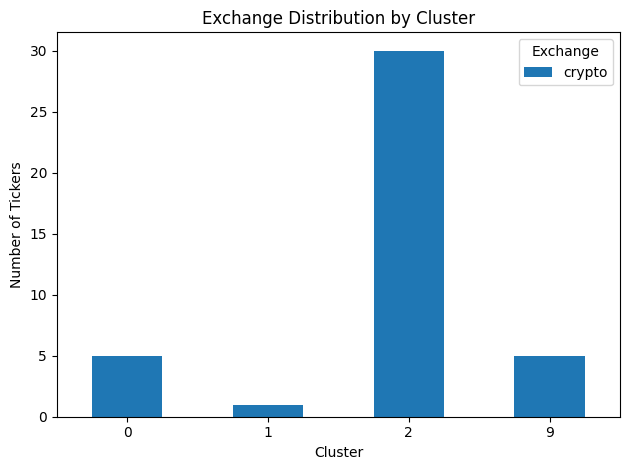

In [11]:
visualise_cryptos_in_clusters(exchanges_dict, cluster_labels, 'ahc', just_cryptos=True, heatmap=False)

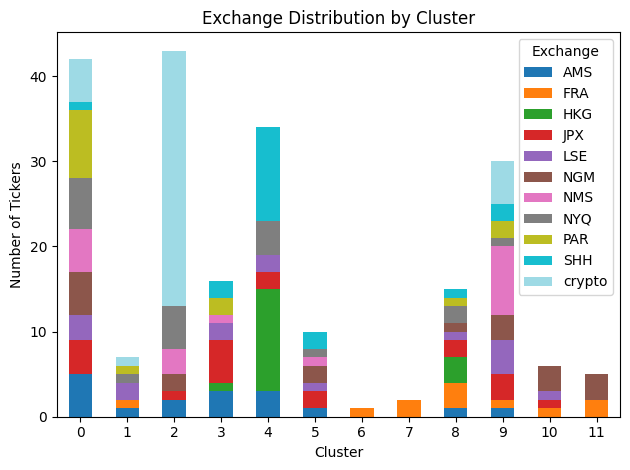

In [12]:
visualise_cryptos_in_clusters(exchanges_dict, cluster_labels, 'ahc', just_cryptos=False, heatmap=False)

In [ ]:
#WHAT

c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


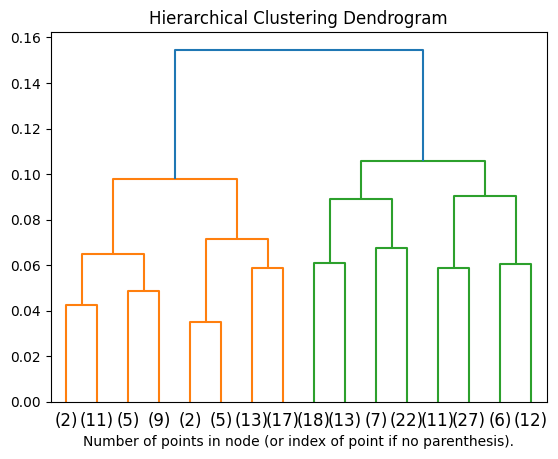

In [13]:
#DO A DENDROGRAM


from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



df_all_stocks = pd.read_csv('stocks_data_new.csv',index_col='Date')
cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')
joined_df = join_stocks_crypto(cryptos_df, df_all_stocks, mode = 'stocks_left')

joined_df.index = pd.to_datetime(joined_df.index)
joined_df_3days = joined_df.resample('3D').last()

df_returns = np.log(joined_df_3days / joined_df_3days.shift(1)).dropna()

df = df_returns.rolling(window=60, center=True).mean().dropna()
#labels, tickers_with_labels_ahc, _, _ = run_clustering_model(df, n_clus=12, model_name='ahc', linkage='complete', return_mode='geometric', n_init=3)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')

model = model.fit(df)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()